#### Data generation from the GAMI-Net paper

In [45]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINet
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

In [47]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def data_generator1(datanum, dist="uniform", random_state=0):
    
    nfeatures = 100
    np.random.seed(random_state)
    x = np.random.uniform(0, 1, [datanum, nfeatures])
    x1, x2, x3, x4, x5, x6 = [x[:, [i]] for i in range(6)]

    def cliff(x1, x2):
        # x1: -20,20
        # x2: -10,5
        x1 = (2 * x1 - 1) * 20
        x2 = (2 * x2 - 1) * 7.5 - 2.5
        term1 = -0.5 * x1 ** 2 / 100
        term2 = -0.5 * (x2 + 0.03 * x1 ** 2 - 3) ** 2
        y = 10 * np.exp(term1 + term2)
        return  y

    y = (8 * (x1 - 0.5) ** 2
        + 0.1 * np.exp(-8 * x2 + 4)
        + 3 * np.sin(2 * np.pi * x3 * x4)
        + cliff(x5, x6)).reshape([-1,1]) + 1 * np.random.normal(0, 1, [datanum, 1])

    task_type = "Regression"
    meta_info = {"X" + str(i + 1):{'type':'continuous'} for i in range(nfeatures)}
    meta_info.update({'Y':{'type':'target'}})         
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)

train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=10000, random_state=0)

#### GAMI-Net training

In [ ]:
## Note the current GAMINet API requires input features being normalized within 0 to 1.
model = GAMINet(meta_info=meta_info, interact_num=0, 
                interact_arch=[40] * 5, subnet_arch=[40] * 5, 
                batch_size=200, task_type=task_type, activation_func=tf.nn.relu, 
                main_effect_epochs=20, interaction_epochs=0, tuning_epochs=0, 
                lr_bp=[0.0001, 0.0001, 0.0001], early_stop_thres=[50, 50, 50],
                heredity=True, loss_threshold=0.01, reg_clarity=1,
                mono_increasing_list=[], mono_decreasing_list=[],
                verbose=True, val_ratio=0.2, random_state=0)

model.fit(train_x, train_y)

val_x = train_x[model.val_idx, :]
val_y = train_y[model.val_idx, :]
tr_x = train_x[model.tr_idx, :]
tr_y = train_y[model.tr_idx, :]
pred_train = model.predict(tr_x)
pred_val = model.predict(val_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5), 
                      np.round(get_metric(val_y, pred_val),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.11464, val loss: 0.11477
Main effects training epoch: 2, train loss: 0.07651, val loss: 0.07658
Main effects training epoch: 3, train loss: 0.03963, val loss: 0.03952
Main effects training epoch: 4, train loss: 0.02089, val loss: 0.02060
Main effects training epoch: 5, train loss: 0.01816, val loss: 0.01778
Main effects training epoch: 6, train loss: 0.01733, val loss: 0.01696
Main effects training epoch: 7, train loss: 0.01667, val loss: 0.01631
Main effects training epoch: 8, train loss: 0.01610, val loss: 0.01576
Main effects training epoch: 9, train loss: 0.01560, val loss: 0.01529
Main effects training epoch: 10, train loss: 0.01514, val loss: 0.01489
Main effects training epoch: 11, train loss: 0.01474, val loss: 0.01454
Main effects training epoch: 12, train loss: 0.01437, val loss: 0.01424
Main effects training e

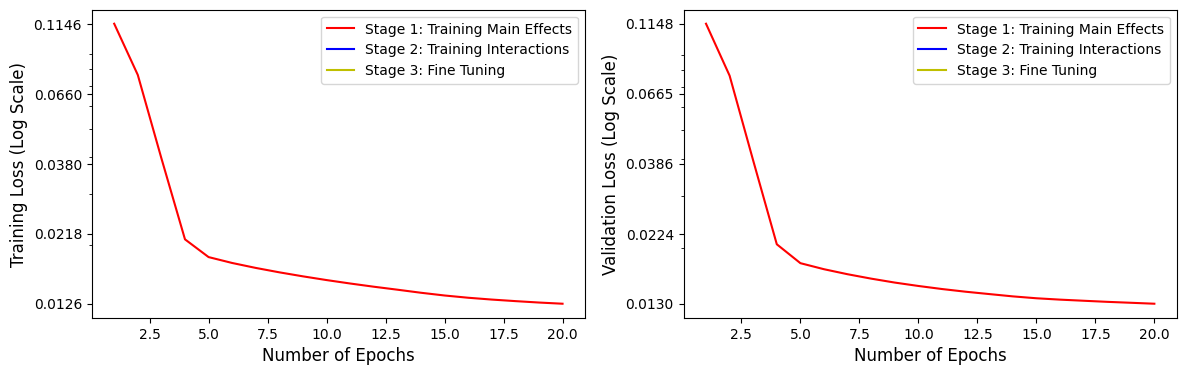

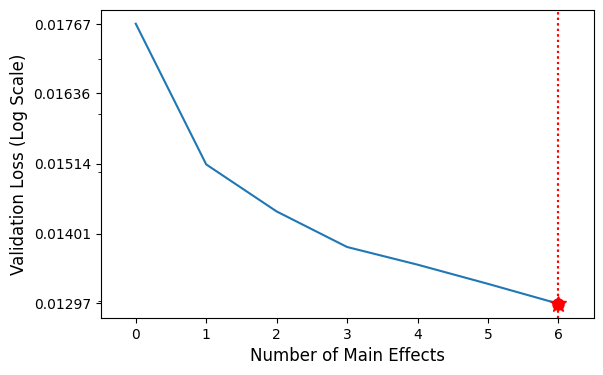

In [39]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True)

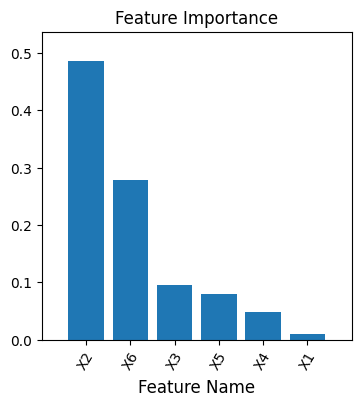

In [40]:
data_dict_global = model.global_explain(save_dict=False)
feature_importance_visualize(data_dict_global, save_png=True, folder=simu_dir, name='s1_feature')

#### NAM training

In [ ]:
import sys
from pathlib import Path

# Get the current working directory
project_root = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()

# Construct relative path to NAM folder
nam_path = project_root / "google-research" / "neural_additive_models"

# Add to Python path if not already there
if nam_path.exists() and str(nam_path) not in sys.path:
    sys.path.append(str(nam_path))

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import data_utils
import models as nam_models
import numpy as np, warnings
if not hasattr(np, "warnings"):
    np.warnings = warnings 
import graph_builder
import os.path as osp
import numpy as np

import matplotlib.pyplot as plt

In [28]:
tf.compat.v1.reset_default_graph()
nn_model = graph_builder.create_nam_model(
    x_train=train_x,
    dropout=0.0,
    num_basis_functions=64,
    activation='relu',
    trainable=True,
    shallow=False,
    name_scope='nam_model')

_ = nn_model(train_x[:1])
nn_model.summary()

Model: "nam_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1 (4.00 B)

 Trainable params: 1 (4.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)


In [30]:
history = nn_model.fit(
    train_x,
    train_y,
    validation_split=0.2,
    batch_size=128,
    epochs=100,
    verbose=1
)


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2187 - mae: 0.4458 - val_loss: 0.1941 - val_mae: 0.4193
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1781 - mae: 0.3977 - val_loss: 0.1571 - val_mae: 0.3725
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1440 - mae: 0.3524 - val_loss: 0.1263 - val_mae: 0.3287
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1159 - mae: 0.3102 - val_loss: 0.1011 - val_mae: 0.2880
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0931 - mae: 0.2718 - val_loss: 0.0808 - val_mae: 0.2510
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0747 - mae: 0.2372 - val_loss: 0.0647 - val_mae: 0.2182
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0603 - mae: 0.2069 - val_loss: 0.0521 - val_mae: 0.1897
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0491 - mae: 0.1812 - val_loss: 0.0424 - val_mae: 0.1655
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.04

In [31]:
from sklearn.metrics import mean_squared_error
import numpy as np

pred_train = nn_model.predict(train_x)
pred_test = nn_model.predict(test_x)

rmse_train = np.sqrt(mean_squared_error(train_y, pred_train))
rmse_test = np.sqrt(mean_squared_error(test_y, pred_test))

print(f"Train RMSE: {rmse_train:.4f}, Test RMSE: {rmse_test:.4f}")


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train RMSE: 0.1396, Test RMSE: 0.1380


In [32]:
print("Scaled RMSE:", get_metric(test_y, pred_test))


Scaled RMSE: 3.2095318239730304


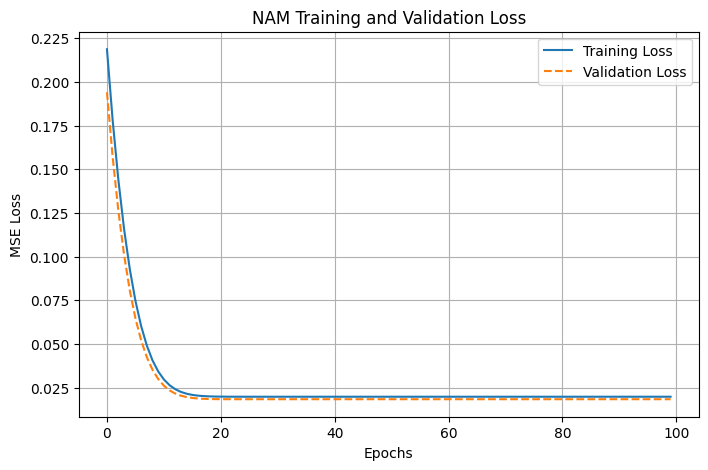

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('NAM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def partition(lst, batch_size):
    lst_len = len(lst)
    index = 0
    while index < lst_len:
      x = lst[index: batch_size + index]
      index += batch_size
      yield x

def generate_predictions(gen, nn_model):
  y_pred = []
  while True:
    try:
      x = next(gen)
      pred = nn_model(x).numpy()
      y_pred.extend(pred)
    except:
      break
  return y_pred

def get_test_predictions(nn_model, x_test, batch_size=256):
  batch_size = min(batch_size, x_test.shape[0])
  generator = partition(x_test, batch_size)
  return generate_predictions(generator, nn_model)

def get_feature_predictions_old(nn_model, features, batch_size=256):
  """Get feature predictions for unique values for each feature."""
  unique_feature_pred, unique_feature_gen = [], []
  for i, feature in enumerate(features):
    batch_size = min(batch_size, feature.shape[0])
    generator = partition(feature, batch_size)
    feature_pred = lambda x: nn_model.feature_nns[i](
        x, training=nn_model._false)
    unique_feature_gen.append(generator)
    unique_feature_pred.append(feature_pred)

  feature_predictions = [
      generate_predictions(generator, feature_pred) for
      feature_pred, generator in zip(unique_feature_pred, unique_feature_gen)
  ]
  feature_predictions = [np.array(x) for x in feature_predictions]
  return feature_predictions

def get_feature_predictions(nn_model, x_data):
    feature_predictions = []
    unique_features = compute_features(x_data)
    for c, i in enumerate(unique_features):
        f_preds = nn_model.feature_nns[c](i, training=nn_model._false)
        feature_predictions.append(f_preds)    
    return feature_predictions

def compute_features(x_data):
  single_features = np.split(x_data, x_data.shape[1], axis=1)
  unique_features = [np.unique(f, axis=0) for f in single_features]
  return unique_features

In [44]:
test_predictions = get_test_predictions(nn_model, test_x)
unique_features = compute_features(train_x)
feature_predictions = get_feature_predictions(nn_model, train_x)
is_regression = True
test_metric = graph_builder.calculate_metric(
    test_y, test_predictions, regression=is_regression)
metric_str = 'RMSE' if is_regression else 'AUROC'
print(f'{metric_str}: {test_metric}')

RMSE: 0.1379702904930305


In [36]:
column_names = [f'X{i+1}' for i in range(train_x.shape[1])]
avg_hist_data = {col: predictions for col, predictions in zip(column_names, feature_predictions)}

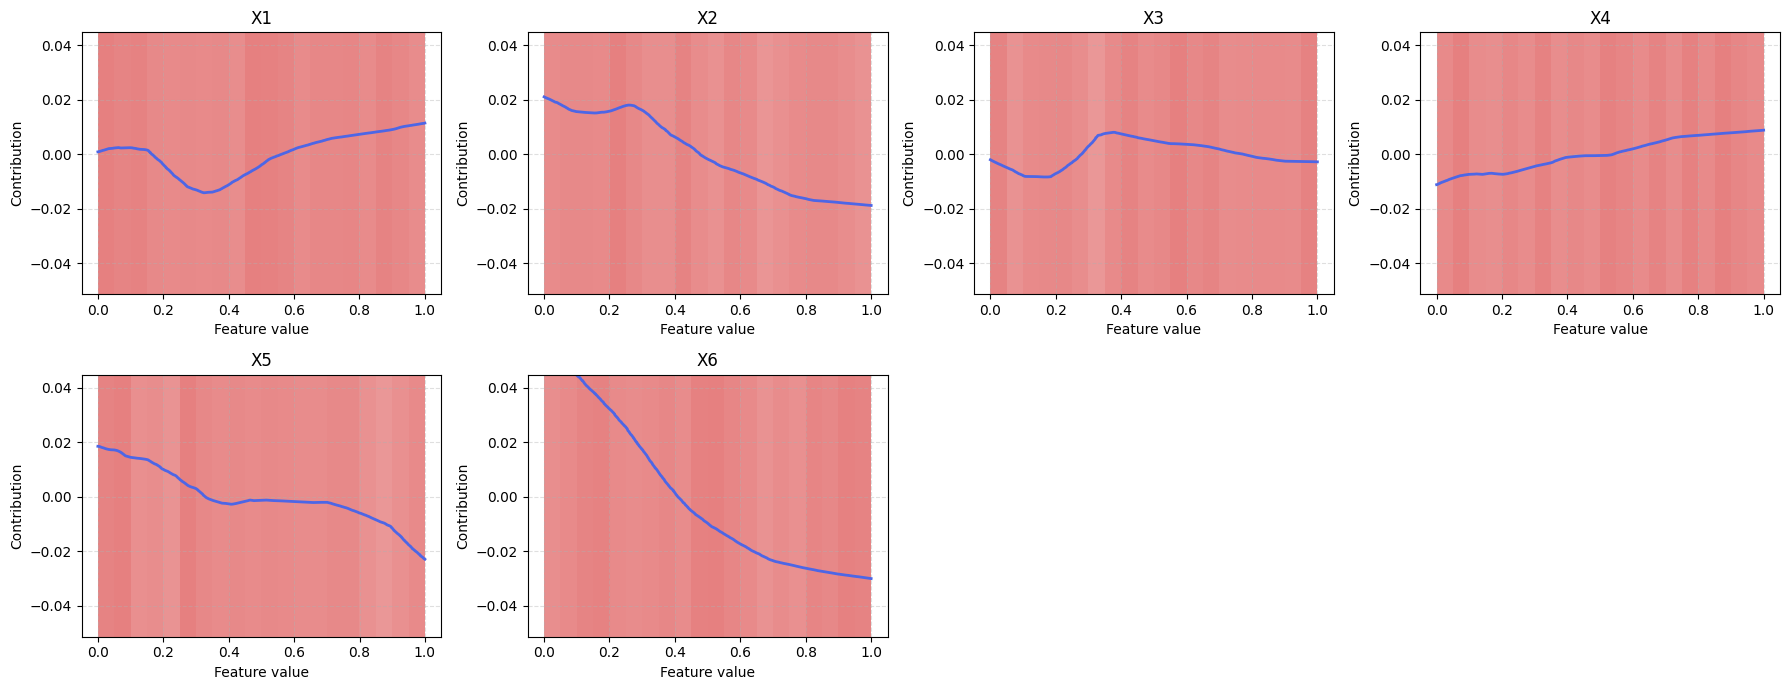

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def shade_by_density_blocks(train_x, num_rows, num_cols,
                            n_blocks=20, color=(0.9, 0.5, 0.5, 0.25),
                            feature_names=None):
    """
    Shade background by the density of feature values in training data.
    """
    n_features = train_x.shape[1]
    feature_names = feature_names or [f"X{i+1}" for i in range(n_features)]
    for i in range(n_features):
        row, col = divmod(i, num_cols)
        ax = plt.subplot(num_rows, num_cols, i+1)
        single_feature_data = train_x[:, i]
        min_x, max_x = np.min(single_feature_data), np.max(single_feature_data)
        bins = np.linspace(min_x, max_x, n_blocks+1)
        counts, _ = np.histogram(single_feature_data, bins=bins)
        counts = counts / np.max(counts) if counts.max() > 0 else counts
        for j in range(n_blocks):
            alpha = 0.05 + 0.95 * counts[j]
            rect = patches.Rectangle(
                (bins[j], ax.get_ylim()[0]),
                bins[j+1] - bins[j],
                ax.get_ylim()[1] - ax.get_ylim()[0],
                linewidth=0,
                facecolor=color,
                alpha=alpha
            )
            ax.add_patch(rect)

def plot_all_hist(feature_predictions, column_names, train_x,
                  num_cols=4, color_base=(0.3, 0.4, 0.9),
                  linewidth=2.0, alpha=1.0,
                  shade_density=True):
    """
    Plot learned shape functions f_i(x_i) for each feature in a NAM.
    feature_predictions: list of numpy arrays (one per feature)
    column_names: list of feature names (e.g., ['X1', 'X2', ...])
    train_x: training data used for density shading
    """
    n_features = len(feature_predictions)
    num_rows = int(np.ceil(n_features / num_cols))
    fig = plt.figure(figsize=(num_cols * 4.5, num_rows * 3.5))
    min_y = min(np.min(p) for p in feature_predictions)
    max_y = max(np.max(p) for p in feature_predictions)
    y_pad = 0.05 * (max_y - min_y)
    min_y -= y_pad
    max_y += y_pad

    for i, (name, pred) in enumerate(zip(column_names, feature_predictions)):
        ax = plt.subplot(num_rows, num_cols, i+1)
        # Build x-axis grid (use sorted training feature values)
        unique_x = np.linspace(np.min(train_x[:, i]), np.max(train_x[:, i]), len(pred))
        mean_pred = np.mean(pred)
        ax.plot(unique_x, pred - mean_pred, color=color_base, linewidth=linewidth, alpha=alpha)
        ax.set_title(name)
        ax.set_ylim(min_y, max_y)
        ax.set_xlabel("Feature value")
        ax.set_ylabel("Contribution")
        ax.grid(True, linestyle="--", alpha=0.4)

    # Optionally overlay density shading
    if shade_density:
        plt.subplots_adjust(hspace=0.35, wspace=0.25)
        shade_by_density_blocks(train_x, num_rows, num_cols,
                                feature_names=column_names)
    plt.tight_layout()
    plt.show()

plot_all_hist(
    feature_predictions=[p.numpy().flatten() for p in feature_predictions],
    column_names=column_names,
    train_x=train_x,
    num_cols=4,
    shade_density=True
)


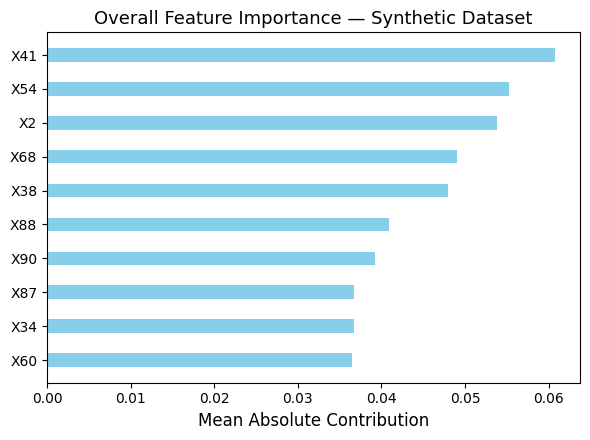

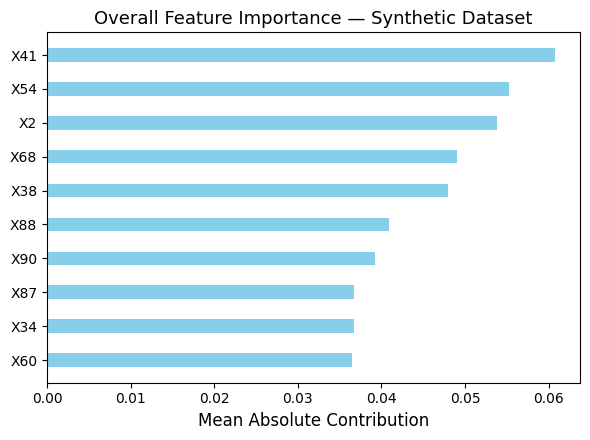

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def compute_mean_feature_importance(avg_hist_data):
    """
    Compute mean absolute deviation of each feature's shape function
    from its mean — a simple importance metric.
    
    avg_hist_data: dict {feature_name: shape_function_values}
                   e.g. from avg_hist_data = {col: preds for col, preds in zip(column_names, feature_predictions)}
    Returns:
        features (list[str])
        mean_abs_scores (list[float])
    """
    mean_abs_score = {}
    for name, preds in avg_hist_data.items():
        preds = np.array(preds).flatten()
        mean_pred = np.mean(preds)
        mean_abs_score[name] = np.mean(np.abs(preds - mean_pred))
    # sort by importance descending
    sorted_items = sorted(mean_abs_score.items(), key=lambda x: x[1], reverse=True)
    features, scores = zip(*sorted_items)
    return features, scores


def plot_mean_feature_importance(features, scores, dataset_name="Synthetic Dataset", width=0.4, color="skyblue"):
    """
    Plot a horizontal bar chart of feature importances.
    """
    fig, ax = plt.subplots(figsize=(6, 4.5))
    y_pos = np.arange(len(features))
    ax.barh(y_pos, scores, height=width, color=color)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features, fontsize=10)
    ax.invert_yaxis()  # highest importance at top
    ax.set_xlabel("Mean Absolute Contribution", fontsize=12)
    ax.set_title(f"Overall Feature Importance — {dataset_name}", fontsize=13)
    plt.tight_layout()
    plt.show()
    return fig
features, scores = compute_mean_feature_importance(avg_hist_data)
top_k = 10
plot_mean_feature_importance(features[:top_k], scores[:top_k])
